# Fit bambi model to males and females combined

In [9]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.25

import jax
import joblib
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PLOT_CONFIG,
    save_factory,
    COLORMAPS,
)
from copy import deepcopy
from operator import or_
from toolz import reduce, valmap, keyfilter, pluck
from aging.behavior.bio_age_model import (
    fit_model,
    masked_xval,
    raise_dim,
    constrained_fit
)
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA, NMF
from scipy.stats import ks_2samp
from itertools import product
from scipy.stats import norm
from itertools import combinations
from sklearn.metrics import median_absolute_error

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.25


In [10]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig4-wheel", tight_layout=False)

In [11]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_


def minmax(df):
    return (df - df.min()) / (df.max() - df.min())

In [12]:
def make_plot(age_df, width, height):
    boundaries = np.arange(age_df["labels"].max() + 2) - 0.5
    pal = sns.blend_palette([COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)], as_cmap=True)
    fig = figure(width, height)
    ax = sns.lineplot(
        data=age_df,
        x="true_ages",
        y="bio_ages",
        hue="labels",
        palette=[COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)],
        legend=False,
        zorder=-1,
        lw=0.25,
        err_kws=dict(lw=0),
    )
    perm = np.random.permutation(len(age_df))
    im = ax.scatter(
        age_df["true_ages"].iloc[perm],
        age_df["bio_ages"].iloc[perm],
        c=age_df["labels"].iloc[perm],
        cmap=pal,
        vmin=0,
        vmax=1,
        s=1,
    )
    cb = fig.colorbar(
        mappable=im,
        boundaries=boundaries,
        ax=ax,
        label="Sex",
    )
    cb.set_ticks(range(0, 2))
    cb.set_ticklabels(["Male", "Female"])
    add_identity(ax, c="k", ls="--", zorder=-2)
    ax.set(
        xlabel="Chronological age (weeks)",
        ylabel="Behavioral age (weeks)",
        aspect="equal",
        xlim=(0, 120),
    )
    sns.despine()
    return fig

In [13]:
def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]
    df = df[use_syllables]
    return df, sizes_col

In [14]:
def read_wheel(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/wheel_raw_counts_matrix_v00_post_processing.parquet"
    )

    df = df[use_syllables]
    df = df.reset_index(level=['experiment_type', 'age_group'])

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/wheel_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    # round ages
    ages = size_df.index.get_level_values('age')
    week_floor = np.round(ages).astype(int)
    size_df = size_df.reset_index(level='age')
    size_df['age'] = week_floor
    size_df = size_df.set_index('age', append=True)

    # fix mouse label
    mice = pd.Series(size_df.index.get_level_values('mouse'))
    size_df = size_df.reset_index('mouse')
    mice.loc[mice == '12wc3_0'] = '12c3_04'
    size_df['mouse'] = mice.to_numpy()
    size_df = size_df.set_index('mouse', append=True)

    df = df.join(size_df[['quant_0.5']])

    df = df.reset_index(level='age')

    # combine consecutive weeks
    df['age'] = (df['age'] // 2) * 2

    df['quant_0.5'] = df.groupby('age')['quant_0.5'].transform(zscore)
    df['quant_0.5'] = df['quant_0.5'].fillna(0)

    df = df.set_index(['age', 'experiment_type', 'age_group'], append=True)

    return df

In [15]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

In [16]:
df, sizes_col = read_male_ontogeny(keep_syllables)

age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

sort_idx = np.argsort(syllable_counts_jax.mean(0))[::-1]

features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": sizes_col.to_numpy()
}

age_sd = 0.125

hypparams = {
    "log_age": True,
    "min_age": 2,
    "max_age": 125,
    "age_sd": age_sd,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.25,
    "n_opt_iter": 100,
    "log_scale_sd": True,
}

## Fit age + size model on male ontogeny data 

In [17]:
mdl = fit_model(features, hypparams, 2, return_loss_on_error=False)

if len(mdl) == 1:
    print(hypparams['n_opt_iter'] - np.isnan(mdl['loss']).sum())

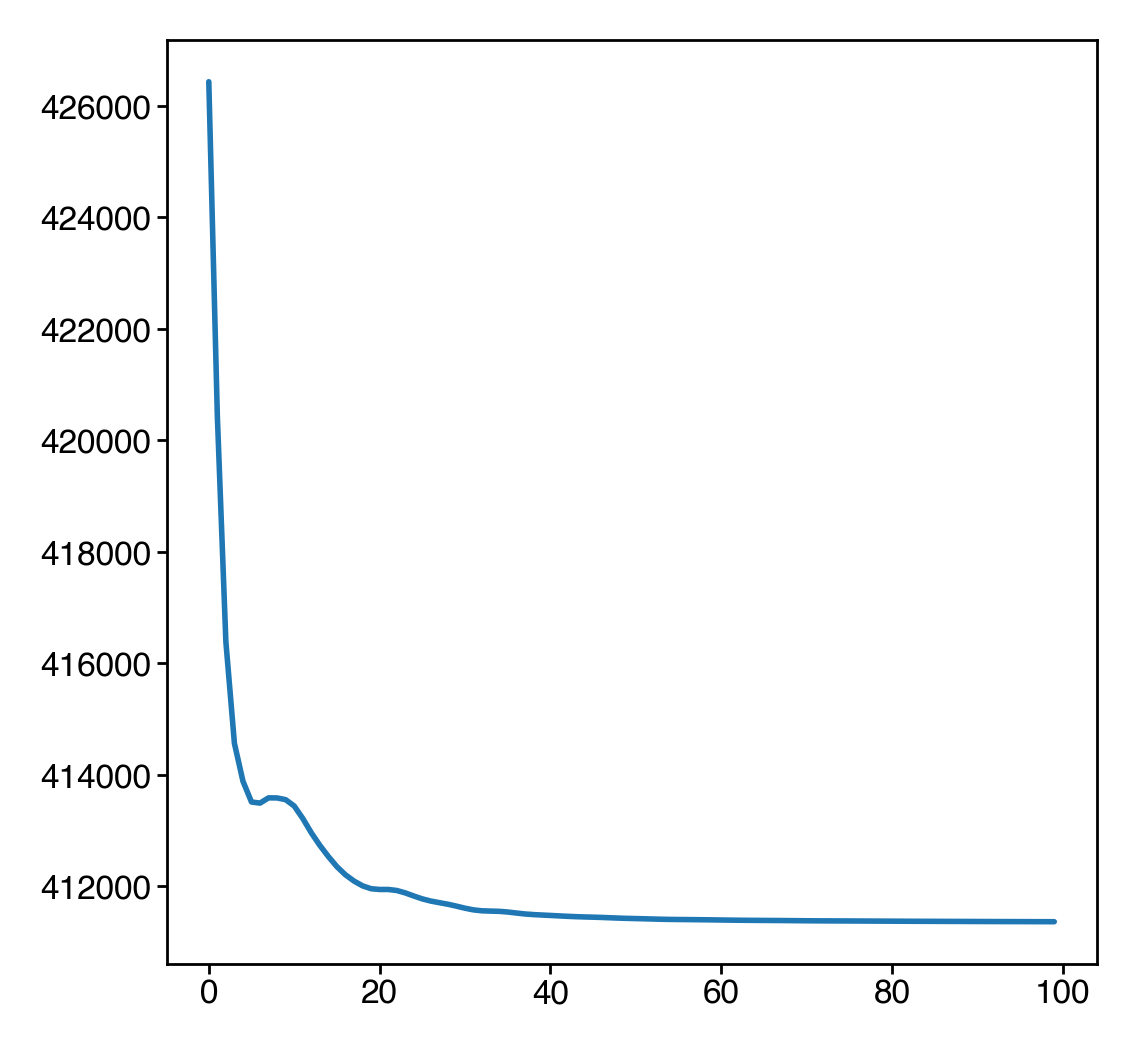

In [18]:
plt.plot(mdl['loss'])

In [19]:
median_absolute_error(mdl['true_ages'], mdl['bio_ages'])

1.9156418

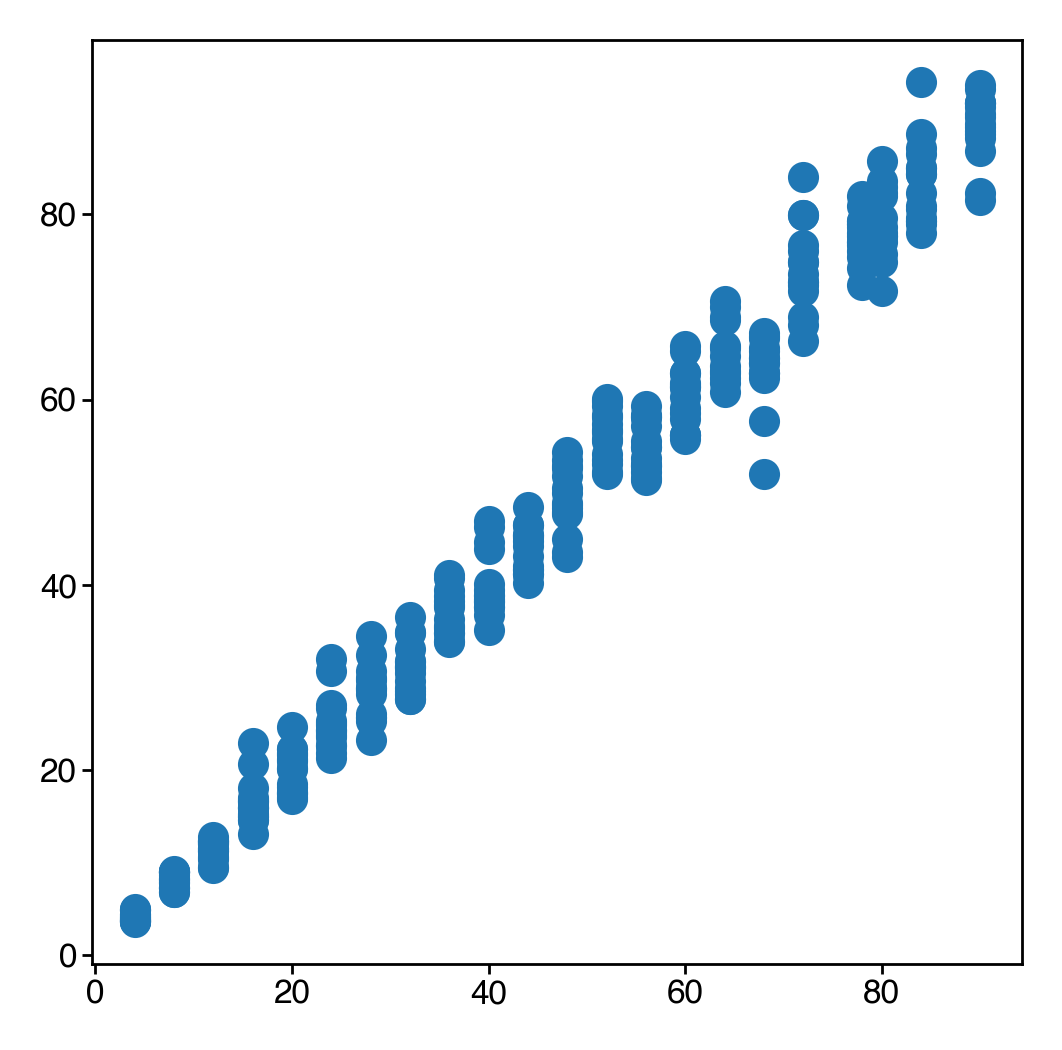

In [20]:
plt.scatter(mdl['true_ages'], mdl['bio_ages'])

## Fit a constrained model on wheel data

- Only fit the individuality parameter

In [21]:
wheel_df = read_wheel(keep_syllables).droplevel(['uuid', 'date', 'subject_name', 'session_name'])

In [22]:
index_names = wheel_df.index.names

In [23]:
wheel_df = wheel_df.groupby(index_names).mean()

In [24]:
wheel_df.head()

0     2      4     5     6     7  \
mouse   age experiment_type age_group                                        
12c1_01 12  control         young      10.5  80.5   64.5  52.5  29.0  33.0   
        14  control         young       5.0  56.0   69.0  88.0  33.0  86.0   
        16  control         young       4.5  44.5   96.0  89.0  29.5  53.5   
        18  control         young       4.0  59.0  140.0  71.0  17.0  37.0   
        20  control         young       5.5  46.0  133.5  74.5  20.5  50.5   

                                           9   10    11    12  ...    79  \
mouse   age experiment_type age_group                          ...         
12c1_01 12  control         young       90.0  5.0  52.5   8.5  ...  41.5   
        14  control         young      131.0  3.0  13.0  10.0  ...  39.0   
        16  control         young      100.5  5.5  28.0  10.5  ...  48.0   
        18  control         young       67.0  8.0  13.0   8.0  ...  66.0   
        20  control         young      102.0  5.5  18.0   5.0  ...  53.0   

                                         83    84    85     90    93    95  \
mouse   age experiment_type age_group                                        
12c1_01 12  control         young      20.5  26.5   6.0   56.5  11.0  12.0   
        14  control         young      20.0  24.0   4.0  115.0  16.0  19.0   
        16  control         young      21.0  24.0  12.0   97.0  22.0  27.0   
        18  control         young      28.0  29.0  13.0   90.0  27.0  20.0   
        20  control         young      12.5  36.0   6.5   81.5  19.0  19.5   

                                         97     98  quant_0.5  
mouse   age experiment_type age_group                          
12c1_01 12  control         young      35.5   46.0  -0.225909  
        14  control         young      23.0   54.0   0.014221  
        16  control         young      44.5  102.5  -0.131969  
        18  control         young      41.0  152.0   0.005032  
        20  control         young      41.5   64.5  -0.313148  

[5 rows x 59 columns]

In [25]:
wheel_size_col = wheel_df['quant_0.5'].to_numpy()

wheel_syllable_counts_jax = jnp.array(wheel_df.drop(columns=['quant_0.5']).astype(float))

In [26]:
wheel_age = wheel_df.index.get_level_values('age')

In [27]:
label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)

mouse_ids = label_encoder.fit_transform(wheel_df.index.get_level_values("mouse").to_numpy()[:, None]).T
mouse_cat = label_encoder.categories_[0]

In [28]:
wheel_features = {
    "ages": jnp.array(wheel_age, dtype=jnp.float32),  # models >= 1
    "counts": wheel_syllable_counts_jax + 1,  # models >= 1
    "sizes": jnp.array(wheel_size_col),
    "mice": jnp.array(mouse_ids),
}

wheel_hypparams = deepcopy(hypparams)
wheel_hypparams["n_animals"] = len(mouse_ids)
wheel_hypparams['n_opt_iter'] = 50
wheel_hypparams['age_sd'] = 0.125

# this forces the identity factors to incorporate an experiment-specific
# syllable offset to account for "batch effects"
# wheel_hypparams['zero_mean'] = False
wheel_hypparams['zero_mean'] = True

In [29]:
fixed_params = mdl['params']

In [30]:
list(fixed_params)

['bio_basis_weights', 'size_slope']

In [31]:
wheel_mdl = constrained_fit(wheel_features, fixed_params, wheel_hypparams, 5, return_loss_on_error=False)

if len(wheel_mdl) == 1:
    print(wheel_hypparams['n_opt_iter'] - np.isnan(wheel_mdl['loss']).sum())

In [32]:
mask = wheel_mdl['true_ages'] > 40
median_absolute_error(wheel_mdl['true_ages'][mask], wheel_mdl['bio_ages'][mask])

5.934311

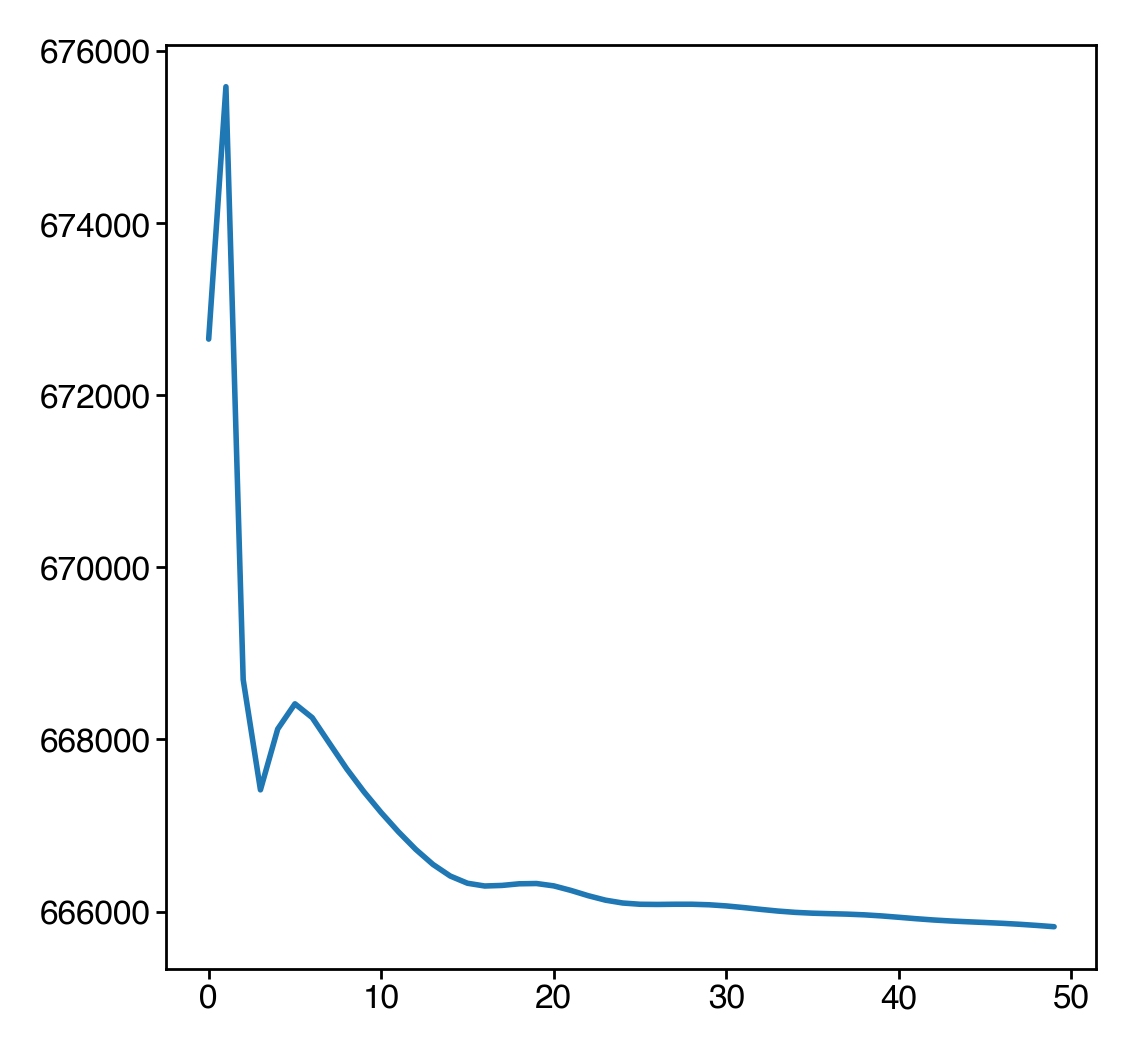

In [33]:
plt.plot(wheel_mdl['loss'])

In [34]:
list(wheel_mdl['params'])

['development_weights', 'individual_biases', 'bio_basis_weights', 'size_slope']

In [35]:
ind_bias = wheel_mdl['params']['individual_biases']
if wheel_hypparams['zero_mean']:
    ind_bias = raise_dim(ind_bias, axis=1)

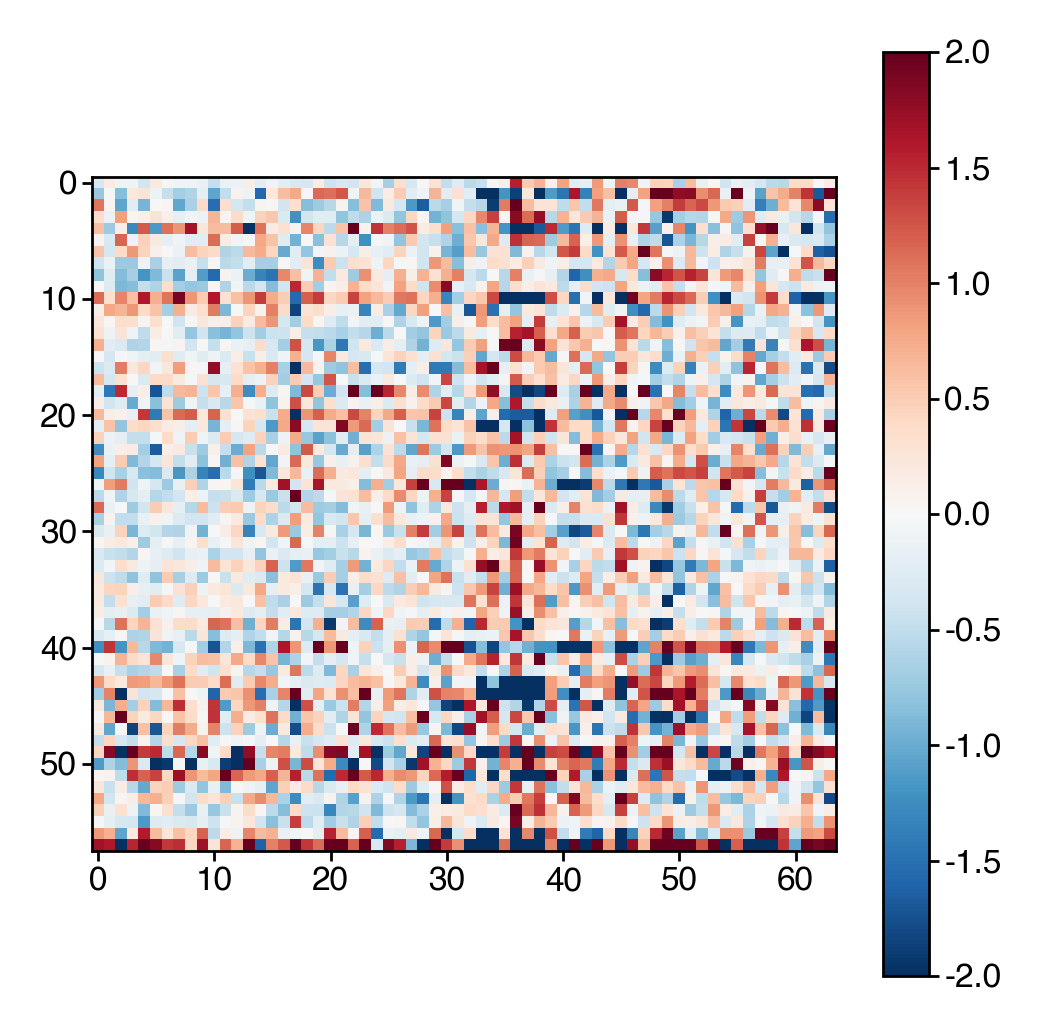

In [36]:
plt.imshow(ind_bias, cmap='RdBu_r', vmin=-2, vmax=2)
plt.colorbar()

<Axes: >

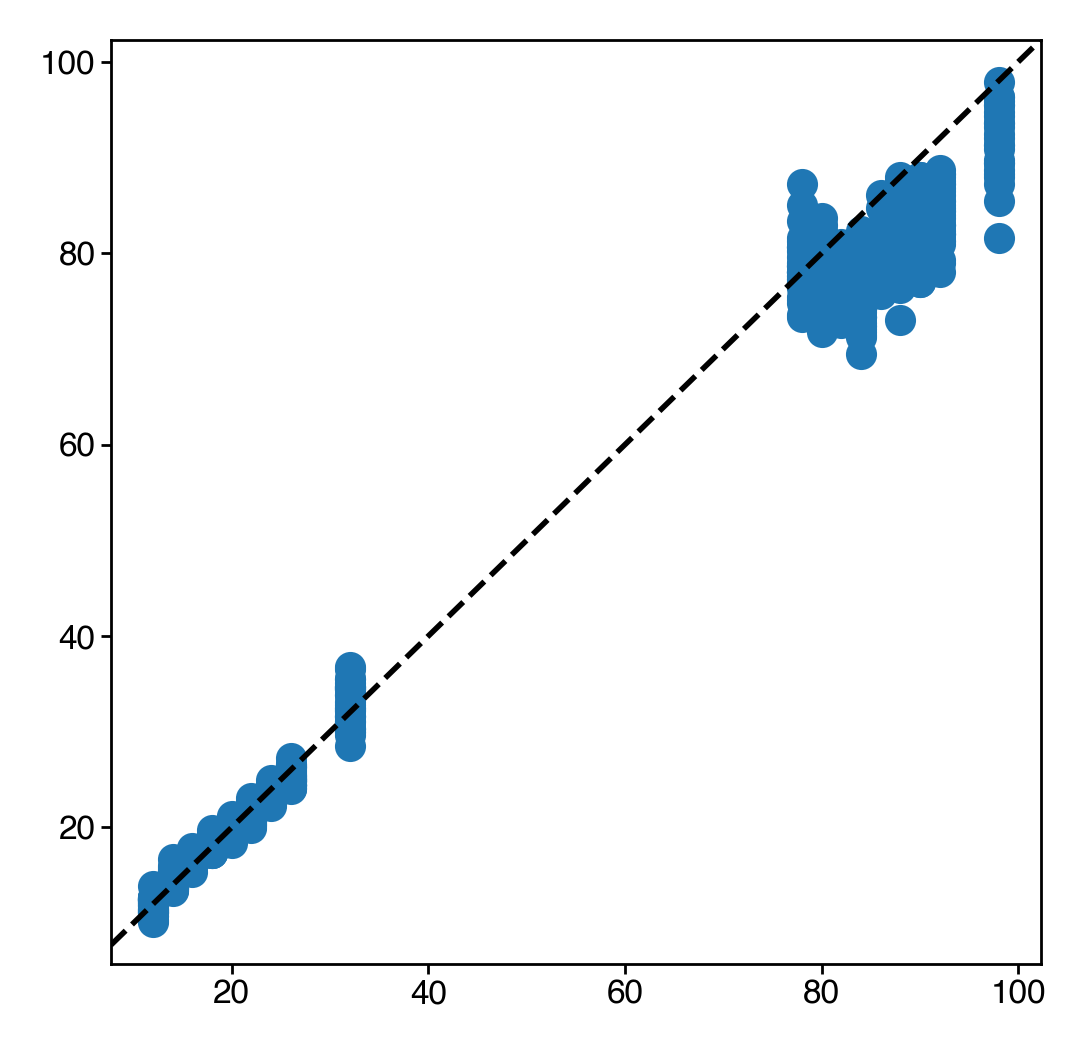

In [37]:
plt.scatter(wheel_mdl['true_ages'], wheel_mdl['bio_ages'])
add_identity(plt.gca(), color='k', ls='--')

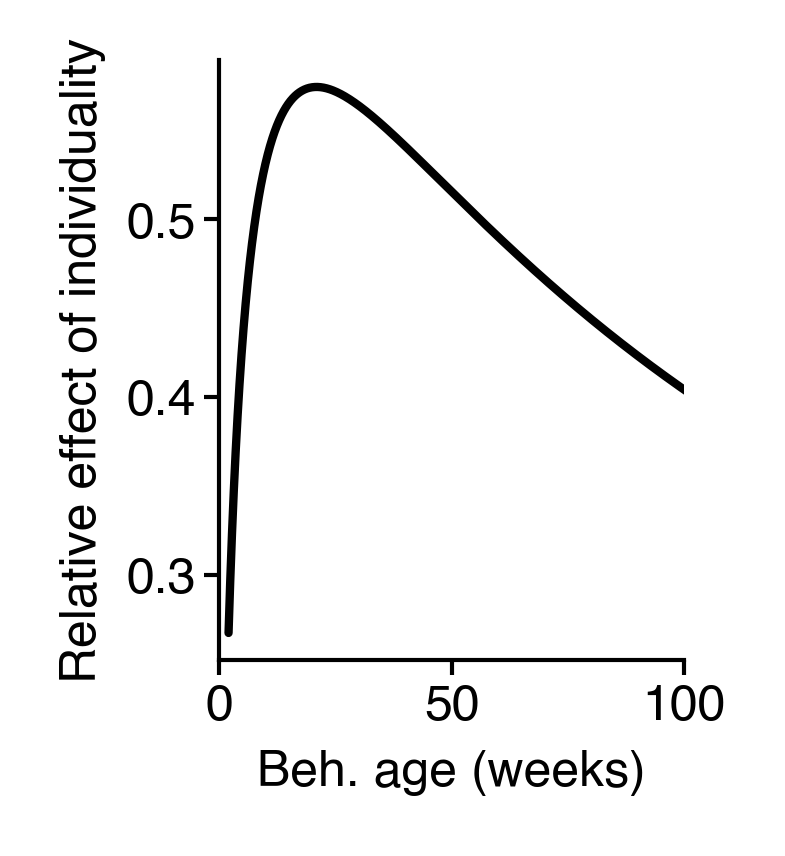

In [38]:
comps = wheel_mdl['init_components']

x = wheel_mdl['params']['development_weights']
dev = np.exp(x @ comps.bases['development']).squeeze()

fig = figure(1, 1.3)
ax = fig.gca()
ax.plot(comps.age_unnormalizer(comps.age_samples), dev, color='k')
plt.xlim(0, 100)
# plt.ylim(0, None)
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Relative effect of individuality")
sns.despine()
saver(fig, "ontogeny-effect-of-sex");

## Make dataframe

In [39]:
wheel_df['beh_age'] = wheel_mdl['bio_ages']

<Axes: xlabel='age', ylabel='beh_age'>

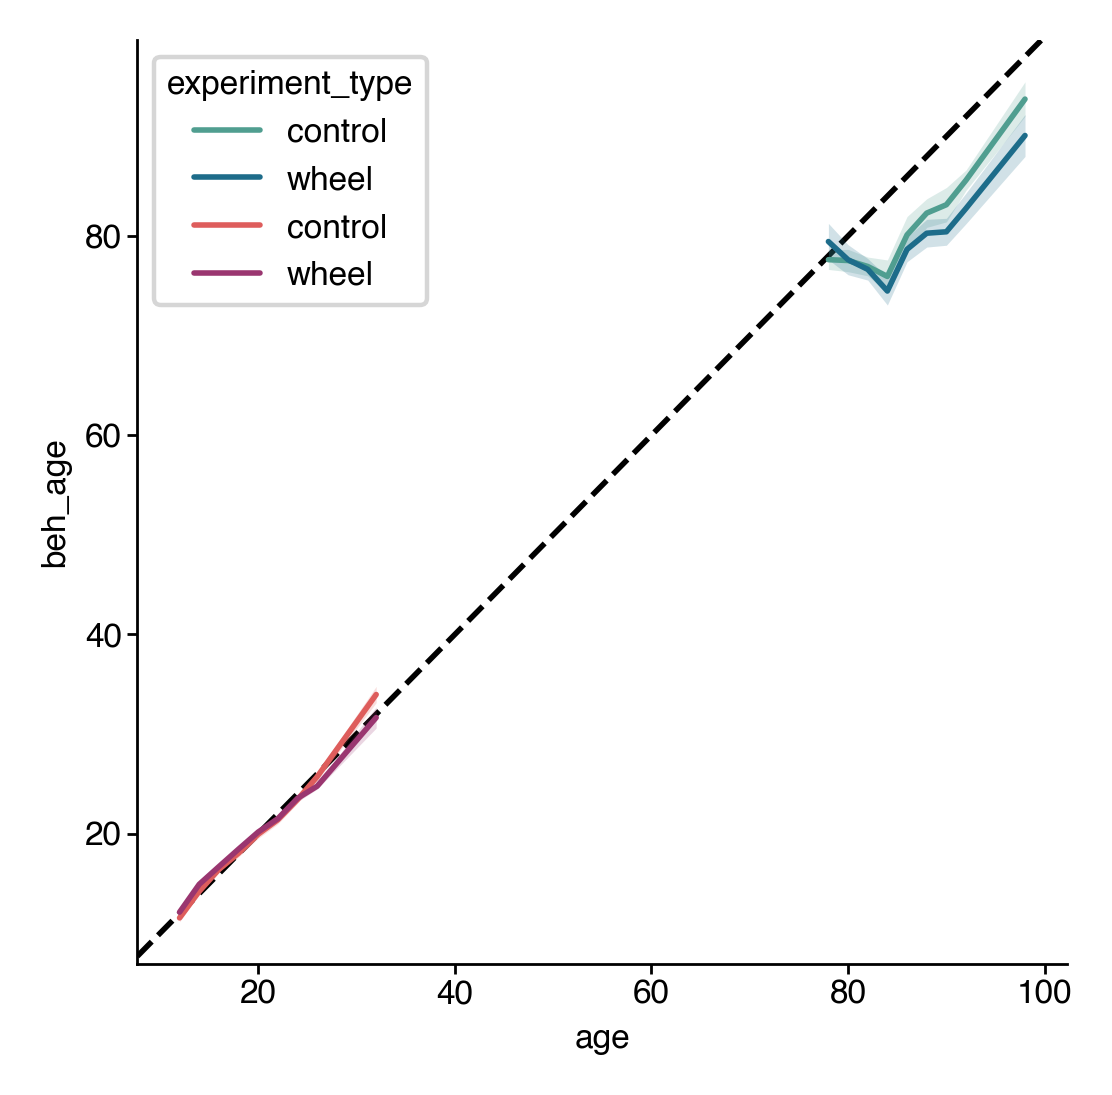

In [40]:
for (g, _df), palette in zip(wheel_df.groupby("age_group"), ["crest", "flare"]):
    sns.lineplot(
        data=_df.reset_index(),
        x="age",
        y="beh_age",
        hue="experiment_type",
        palette=palette,
        errorbar=("se", 2),
        err_kws=dict(lw=0),
    )
sns.despine()
add_identity(plt.gca(), color='k', ls='--', zorder=-1)

In [41]:
diff_samples = []
for i in range(500):
    diffs = []
    for age, _df in wheel_df.reset_index().groupby("age"):
        cb = (
            _df.loc[_df["experiment_type"] == "control", "beh_age"]
            .sample(frac=1, replace=True, random_state=i)
            .mean()
        )
        wb = (
            _df.loc[_df["experiment_type"] == "wheel", "beh_age"]
            .sample(frac=1, replace=True, random_state=i)
            .mean()
        )
        diffs.append((age, wb - cb))
    diffs = dict(diffs)
    diff_samples.append(diffs)

In [42]:
diff_samples = pd.DataFrame(diff_samples)
diff_samples.columns.name = 'age'

In [43]:
melt_diff = diff_samples.T.reset_index().melt(id_vars='age')

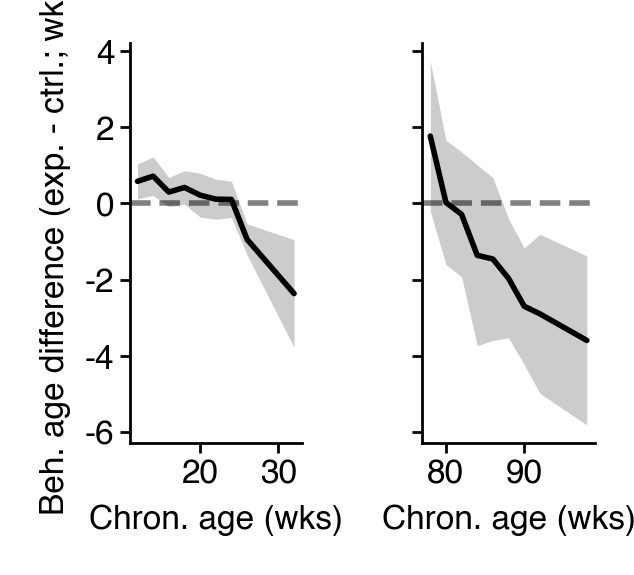

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(1.5, 1.3), sharey=True, gridspec_kw={'wspace': 0.7})
for i in range(2):
    if i == 0:
        plt_data = melt_diff.query('age < 50')
    else:
        plt_data = melt_diff.query('age > 50')
    a = sns.lineplot(data=plt_data, x='age', y='value', errorbar=('sd', 2), color='k', err_kws=dict(lw=0), ax=ax[i])
    a.axhline(0, ls='--', color='gray', zorder=-1)
    a.set(ylabel="Beh. age difference (exp. - ctrl.; wks)", xlabel="Chron. age (wks)")
sns.despine()
saver(fig, "wheel-residuals-bambi");

In [203]:
out = []
for (exp, age_group, mouse), _df in wheel_df.groupby(['experiment_type', 'age_group', 'mouse']):
    avgd_age = _df.sort_index(level='age', ascending=False)['beh_age'].rolling(5, center=True, min_periods=1, win_type="exponential").mean(tau=1.0).iloc[::2].iloc[::-1]
    out.append(avgd_age - avgd_age.values[0])

In [204]:
out = pd.concat(out).reset_index()

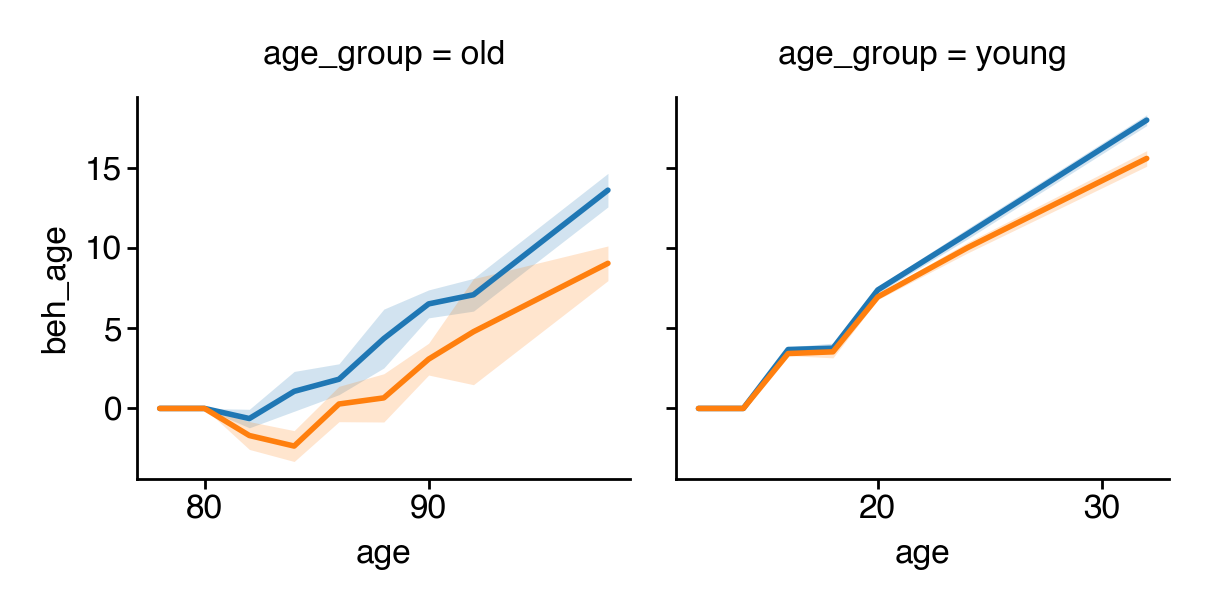

In [205]:
fgrid = sns.FacetGrid(data=out, col="age_group", sharex=False, height=1.5, hue="experiment_type")
fgrid.map(sns.lineplot, "age", "beh_age", errorbar=("se", 1), err_kws=dict(lw=0))

In [37]:
# TODO: before after wheel treatment

## Plot velocity

In [1]:
import polars as pl

In [68]:
full_df = pl.scan_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/wheel_syllable_df_v00.parquet')

avg_velocities = full_df.group_by(
    ['uuid', 'age', 'mouse']
).agg(pl.col("velocity_2d_mm").mean() * 30).collect()

In [ ]:
pd_avg_velocities = avg_velocities.to_pandas()
ages = pd_avg_velocities['age']
week_floor = np.round(ages).astype(int)
pd_avg_velocities['age'] = week_floor
pd_avg_velocities['age'] = (pd_avg_velocities['age'] // 2) * 2
pd_avg_velocities = pd_avg_velocities.groupby(['mouse', 'age'])['velocity_2d_mm'].mean()

joined_df = wheel_df.reset_index(level=['experiment_type', 'age_group']).join(pd_avg_velocities)
joined_df = joined_df.set_index(['experiment_type', 'age_group'], append=True)
joined_df = joined_df.rename_axis(index={'experiment_type': 'exp', 'age_group': 'grp'})

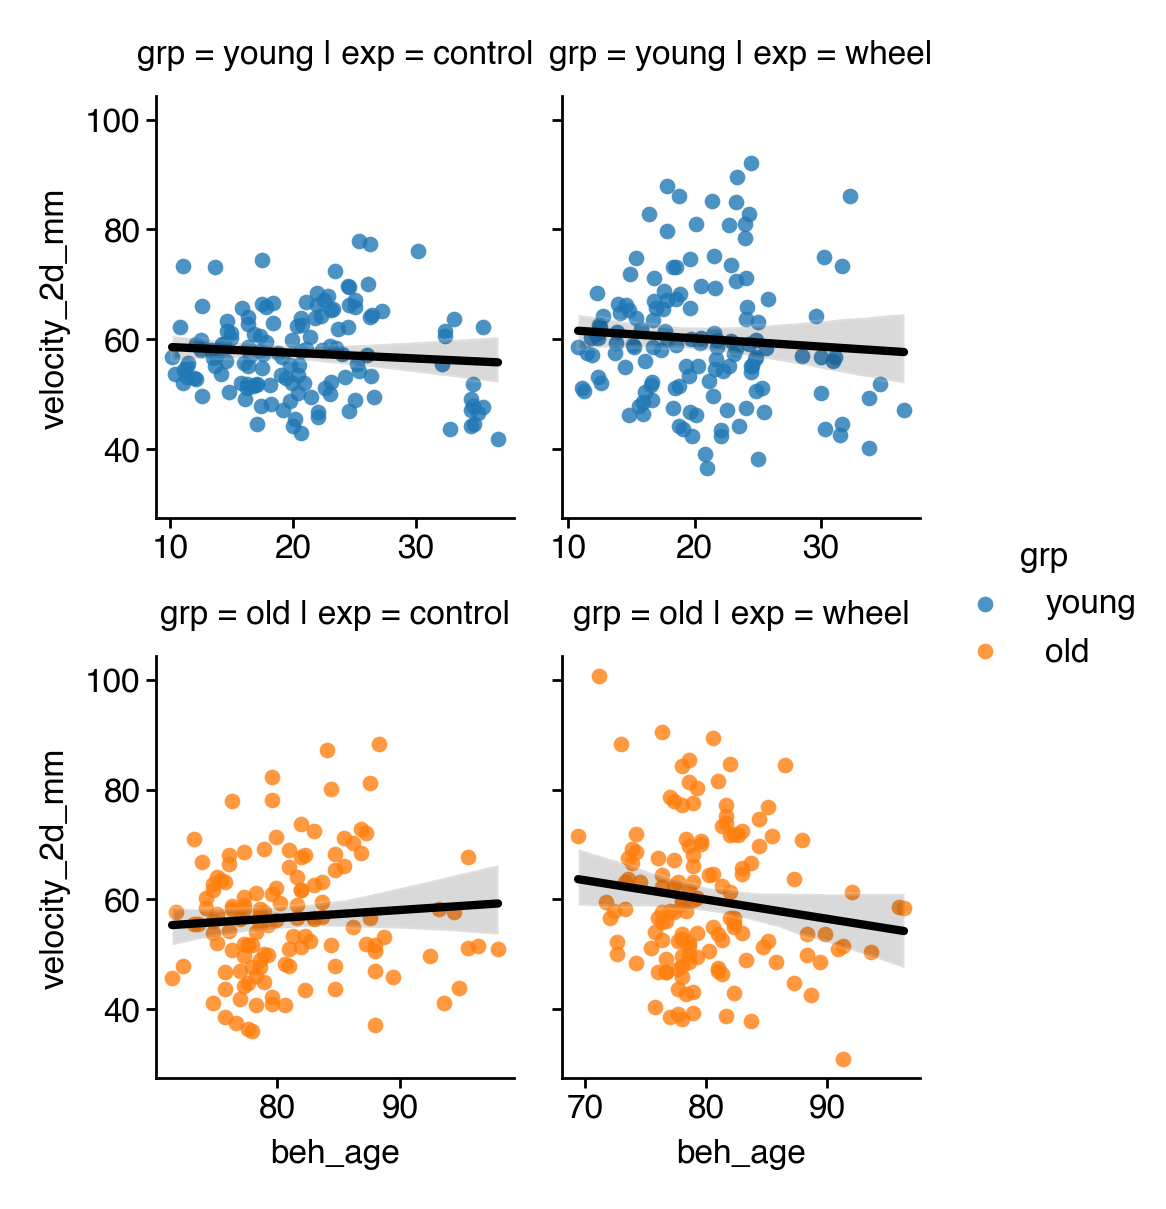

In [84]:
fgrid = sns.FacetGrid(data=joined_df.reset_index(), col='exp', row="grp", hue='grp', height=1.5, sharex=False, aspect=0.8)
fgrid.map(sns.regplot, 'beh_age', 'velocity_2d_mm', scatter_kws=dict(linewidths=0, s=8), line_kws=dict(color='k'))
fgrid.add_legend()

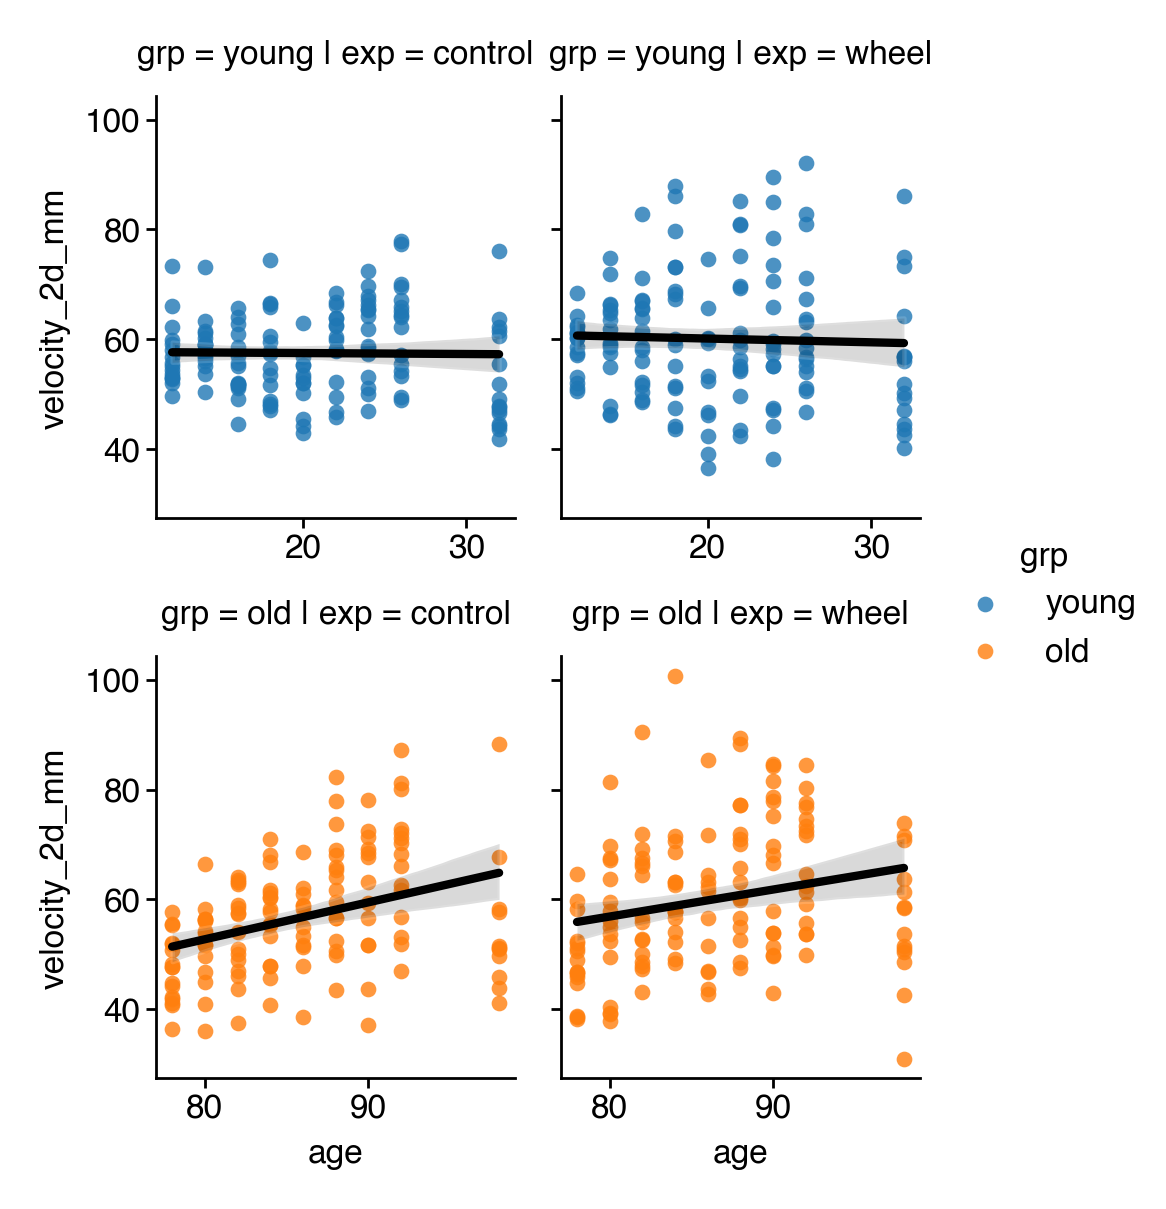

In [85]:
fgrid = sns.FacetGrid(data=joined_df.reset_index(), col='exp', row="grp", hue='grp', height=1.5, sharex=False, aspect=0.8)
fgrid.map(sns.regplot, 'age', 'velocity_2d_mm', scatter_kws=dict(linewidths=0, s=8), line_kws=dict(color='k'))
fgrid.add_legend()